In [47]:
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries
import numpy as np
import matplotlib.pyplot as plt
import ringdown.qnms
import makefun
from scipy.optimize import curve_fit
import statistics

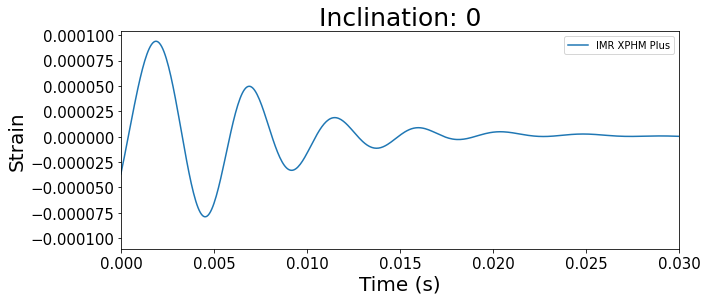

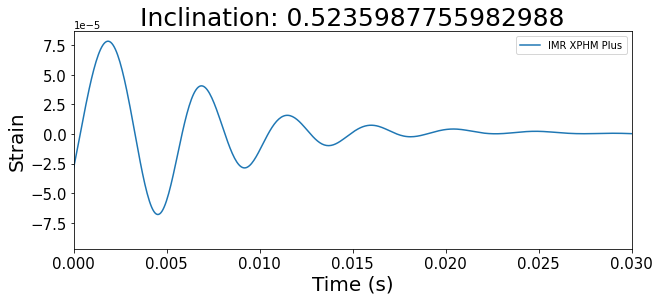

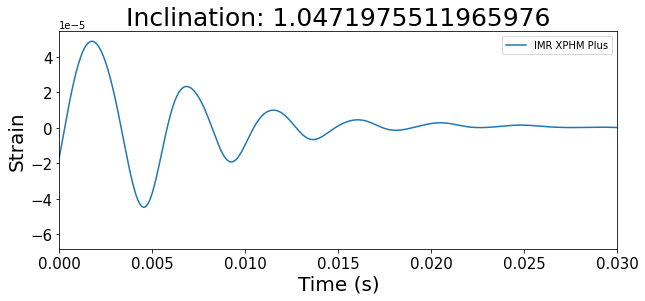

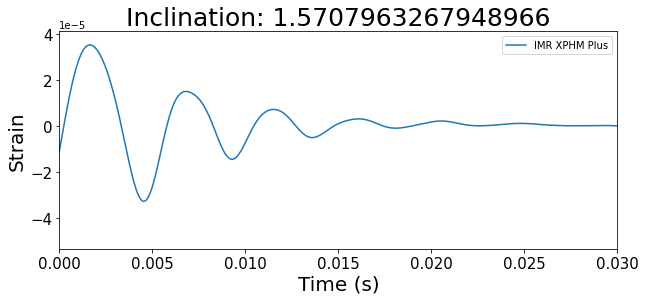

In [3]:
inclination = [0, np.pi/6, np.pi/3, np.pi/2]
for i in inclination:        
    hp, hc = get_td_waveform(approximant="IMRPhenomXPHM",
                                mass1=40,
                                mass2=40,
                                delta_t=1.0/16384,
                                f_lower=30,
                                distance=1e-14,
                                inclination=i,
                                spin1x=0,
                                spin1y=0,
                                spin1z=0,
                                spin2x=0,
                                spin2y=0,
                                spin2z=0)

    # sample times ---> timeseries
    hp_smp_ts = TimeSeries(hp.sample_times, delta_t=1/16384, epoch=0)
    cond = hp_smp_ts.crop(0.645,0)                                      

    # h+/hx data ---> timeseries
    hp_data = TimeSeries(hp, delta_t=1/16384, epoch=0)  
    cond_hp = hp_data.crop(0.645,0)
    hp_signal = cond_hp.numpy()                  

    # repeat
    hc_data = TimeSeries(hc, delta_t=1/16384, epoch=0)              
    cond_hc = hc_data.crop(0.645,0)
    hc_signal = cond_hc.numpy()                                         

    # use for hp+hc ringdown analysis
    time = cond.numpy()             
    
    plt.figure(figsize=(10,4))
    plt.plot(cond, cond_hp, label='IMR XPHM Plus')
    plt.xlim(0, 0.03)
    plt.legend()
    plt.title(f'Inclination: {i}',fontsize=25)
    plt.xlabel('Time (s)',fontsize=20)
    plt.ylabel('Strain',fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

In [4]:
# define what modes to use
def rd_fun(modes=[(2,2,0),(2,2,1)]):
    #create function signature
    func_signature="rngdwn_multi_modes(time,M,chi"
    # loop through defined modes
    for mode in modes:
        l,m,n = mode
        func_signature+= f",a{l}{m}{n},phi{l}{m}{n}"
    func_signature+=")"
    # kwargs = a220, phi220, a221, phi221, ...
    def new_fun(time,M,chi,**kwargs):
        # creating empty time array to hold rngdwn() return
        ex = np.zeros(time.shape)
        # loop through defined modes
        for mode in modes:
            l,m,n=mode
            amplitude=kwargs[f"a{l}{m}{n}"]
            phi=kwargs[f"phi{l}{m}{n}"]
            # add back to empty time array  
            ex += rngdwn(time,M,chi,l,m,n,amplitude,phi)
            #print(time,M,chi,kwargs)
        # return ex to have combined signal for all defined modes
        return ex
    # this fx now looks like what scipy.curve_fit expects...
    return makefun.create_function(func_signature,new_fun)

# let "test = rd_fun" // test now takes inputs of (time,M,chi,a220,phi220,a221,phi221) --> curve_fit can play with
test = rd_fun(modes=[(2,1,0),(2,1,1),(2,1,2),(2,2,0),(2,2,1),(2,2,2),(3,2,0),(3,2,1),(3,2,2),(3,3,0),(3,3,1),(3,3,2),(4,4,0),(4,4,1),(4,4,2)]
             )

In [5]:
def rngdwn(time,M,chi,l,m,n,amplitude,phi):
    # using get_ftau to retrieve frequency and damping time for given values (ftau = [freq, tau])
    ftau = ringdown.qnms.get_ftau(M,chi,n,l,m)
    gamma = (ftau[1])**-1
    t0=0
        
    wf_kws = dict(
    A = amplitude,
    phi = phi,
    f = ftau[0],                                                            
    gamma = gamma,                                                          
    )
        
    def get_signal(time, A, phi, f, gamma):
        # generate sinusoid
        s = A*np.cos(2*np.pi*f*(time-t0) + phi)*np.exp(-gamma*abs(time-t0))
        return ringdown.Data(s, index=time)

    signal = get_signal(time, **wf_kws)
    
    return signal

In [70]:
def plot_ringdown(x0,xdata,ydata,p0,bounds):  

    popt,pcov = curve_fit(x0,xdata,ydata,p0,bounds=bounds)
    print(*popt)
    print(popt[0],popt[1],popt[8],popt[9],popt[10],popt[11],popt[12],popt[13],popt[20],popt[21])
    fig1, ax1 = plt.subplots(figsize=(10,4))
    ax2 = ax1.twiny()
    ax1.set_xlim(0,.03)
    ax2.set_xlim(0,.03)
    ax1.set_xlabel('Time (s)',fontsize=20)
    ax1.set_ylabel('Strain',fontsize=20)
    ax2.set_frame_on(False)             
    ax2.get_xaxis().tick_bottom()           
    ax2.axes.get_xaxis().set_visible(False)
    ax1.tick_params(axis='both',labelsize=15)
    ax2.tick_params(axis='both',labelsize=15)

    ax1.plot(xdata, ydata, label='IMRPhenomXPHM Plus',c='blue')
    ax2.plot(xdata, test(xdata, *popt),label='scipy.curve_fit',c='orange')
    #ax1.set_title('',fontsize=25)
    ax1.legend(bbox_to_anchor=(1, 1),loc='upper right',fontsize=15)
    ax2.legend(bbox_to_anchor=(1, .85),loc='upper right',fontsize=15)

In [71]:
def two_two_zero(time,M,chi,a220,phi220):
    #pylab.figure(figsize=pylab.figaspect(0.4))
    ftau = ringdown.qnms.get_ftau(M,chi,0,2,2)
    gamma = (ftau[1])**-1
    t0=0
    time = cond.numpy()
        
    wf_kws = dict(
    A = a220,
    phi = phi220,
    f = ftau[0],
    gamma = gamma,
    )
        
    def get_signal(time, A, phi, f, gamma):
        s = A*np.cos(2*np.pi*f*(time-t0) + phi)*np.exp(-gamma*abs(time-t0))
        return ringdown.Data(s, index=time)

    signal = get_signal(time, **wf_kws)

    return signal


def two_two_one(time,M,chi,a221,phi221):
    #pylab.figure(figsize=pylab.figaspect(0.4))
    ftau = ringdown.qnms.get_ftau(M,chi,1,2,2)
    gamma = (ftau[1])**-1
    t0=0
    time = cond.numpy()
        
    wf_kws = dict(
    A = a221,
    phi = phi221,
    f = ftau[0],
    gamma = gamma,
    )
        
    def get_signal(time, A, phi, f, gamma):
        s = A*np.cos(2*np.pi*f*(time-t0) + phi)*np.exp(-gamma*abs(time-t0))
        return ringdown.Data(s, index=time)

    signal = get_signal(time, **wf_kws)

    return signal


def two_two_two(time,M,chi,a222,phi222):
    #pylab.figure(figsize=pylab.figaspect(0.4))
    ftau = ringdown.qnms.get_ftau(M,chi,2,2,2)
    gamma = (ftau[1])**-1
    t0=0
    time = cond.numpy()
        
    wf_kws = dict(
    A = a222,
    phi = phi222,
    f = ftau[0],
    gamma = gamma,
    )
        
    def get_signal(time, A, phi, f, gamma):
        s = A*np.cos(2*np.pi*f*(time-t0) + phi)*np.exp(-gamma*abs(time-t0))
        return ringdown.Data(s, index=time)

    signal = get_signal(time, **wf_kws)

    return signal


def three_three_zero(time,M,chi,a330,phi330):
    #pylab.figure(figsize=pylab.figaspect(0.4))
    ftau = ringdown.qnms.get_ftau(M,chi,0,3,3)
    gamma = (ftau[1])**-1
    t0=0
    time = cond.numpy()
        
    wf_kws = dict(
    A = a330,
    phi = phi330,
    f = ftau[0],
    gamma = gamma,
    )
        
    def get_signal(time, A, phi, f, gamma):
        s = A*np.cos(2*np.pi*f*(time-t0) + phi)*np.exp(-gamma*abs(time-t0))
        return ringdown.Data(s, index=time)

    signal = get_signal(time, **wf_kws)

    return signal

In [72]:
# making large bound arrays for function input
gb = np.array([1e-4, np.pi])
guess_bounds = np.tile(gb, 15)
m_chi = [62,0.68]
con = np.concatenate((m_chi, guess_bounds))

lower = np.array([1e-6, 0])
lower_bound = np.tile(lower, 15)
m_chi_lower = [50,0.3]
con_lower = np.concatenate((m_chi_lower,lower_bound))

upper = np.array([1e-3, 2*np.pi])
upper_bound = np.tile(upper, 15)
m_chi_upper = [95, 0.85]
con_upper = np.concatenate((m_chi_upper, upper_bound))

91.12073483821509 0.8499995703457611 6.93697808158022e-05 1.6850326127714976 0.0009998165492567596 5.046196509097158 0.0009699774005038488 2.087943550098099 0.00010538776806812382 2.4288427162832553 1.1641869273993385e-06 6.283185307179585 1.6105118422137586e-06 6.283185307170839 1.013205036369573e-05 2.260826517819801 1.2901245320508251e-06 6.283185078779059 0.00020214388971527412 6.28318530717918 1.940851352116671e-05 5.256801110312687 0.00018987962670412572 2.99496793481755 0.00023194031005999247 6.283185223665369 4.622445113371786e-06 1.487744872321543 2.1952023102650553e-05 4.296556393220079 4.6738061956914085e-05 3.557249940651353
91.12073483821509 0.8499995703457611 0.00010538776806812382 2.4288427162832553 1.1641869273993385e-06 6.283185307179585 1.6105118422137586e-06 6.283185307170839 1.940851352116671e-05 5.256801110312687


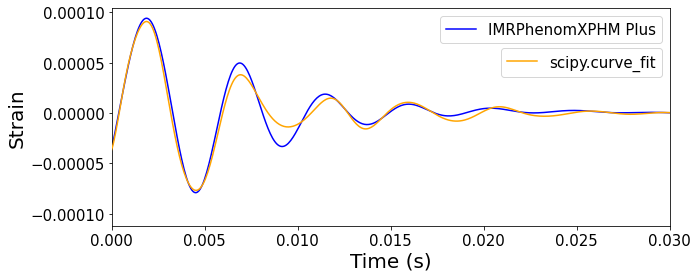

In [73]:
import matplotlib.lines as mlines
# plotting
x0 = test
xdata = time
ydata = cond_hp
p0 = con
bounds = (con_lower, con_upper)
plot_ringdown(x0,xdata,ydata,p0,bounds)
#I = mlines.Line2D([],[],color='white', label=f'Inclination:{i}')
#M1 = mlines.Line2D([],[],color='white', label=f'M1:{mass1}')
#M2 = mlines.Line2D([],[],color='white', label=f'M2:{mass2}')
#SPIN1 = mlines.Line2D([],[],color='white', label=f'Spin1(x,y,z):{spin1x}{spin1y}{spin1z}')
#SPIN2 = mlines.Line2D([],[],color='white', label=f'Spin2(x,y,z):{spin2x}{spin2y}{spin2z}')
#plt.legend(handles=[I,M1,M2,SPIN1,SPIN2],loc='lower right',frameon=False)

In [74]:
def XPHMringdown_plots(mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,x0,p0,bounds):
    inclination = [0, np.pi/6, np.pi/3, np.pi/2]
    for i in inclination:        
        hp, hc = get_td_waveform(approximant="IMRPhenomXPHM",
                                 mass1=mass1,
                                 mass2=mass2,
                                 delta_t=1.0/16384,
                                 f_lower=30,
                                 distance=1e-14,
                                 inclination=i,
                                 spin1x=spin1x,
                                 spin1y=spin1y,
                                 spin1z=spin1z,
                                 spin2x=spin2x,
                                 spin2y=spin2y,
                                 spin2z=spin2z)

        # sample times ---> timeseries
        hp_smp_ts = TimeSeries(hp.sample_times, delta_t=1/16384, epoch=0)
        cond = hp_smp_ts.crop(0.645,0)                                      

        # h+/hx data ---> timeseries
        hp_data = TimeSeries(hp, delta_t=1/16384, epoch=0)  
        cond_hp = hp_data.crop(0.645,0)
        hp_signal = cond_hp.numpy()                  

        # repeat
        hc_data = TimeSeries(hc, delta_t=1/16384, epoch=0)              
        cond_hc = hc_data.crop(0.645,0)
        hc_signal = cond_hc.numpy()                                         

        # use for hp+hc ringdown analysis
        time = cond.numpy()             
        
        '''plt.figure(figsize=(10,4))
        plt.plot(cond, cond_hp, label='IMR XPHM Cross')
        plt.xlim(0, 0.03)
        plt.title('IMRPhenomXPHM Ringdown WF',fontsize=25)
        plt.xlabel('Time (s)',fontsize=20)
        plt.ylabel('Strain',fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)'''
        
        x0 = x0
        xdata = time
        ydata = cond_hp
        p0 = p0
        bounds = bounds
        plot_ringdown(x0,xdata,ydata,p0,bounds)
        
        I = mlines.Line2D([],[],color='white', label=f'Inclination:{i}')
        M1 = mlines.Line2D([],[],color='white', label=f'M1:{mass1}')
        M2 = mlines.Line2D([],[],color='white', label=f'M2:{mass2}')
        SPIN1 = mlines.Line2D([],[],color='white', label=f'Spin1(x,y,z):{spin1x},{spin1y},{spin1z}')
        SPIN2 = mlines.Line2D([],[],color='white', label=f'Spin2(x,y,z):{spin2x},{spin2y},{spin2z}')
        plt.legend(handles=[I,M1,M2,SPIN1,SPIN2],loc='lower right',frameon=False,fontsize=12)

91.12073483821509 0.8499995703457611 6.93697808158022e-05 1.6850326127714976 0.0009998165492567596 5.046196509097158 0.0009699774005038488 2.087943550098099 0.00010538776806812382 2.4288427162832553 1.1641869273993385e-06 6.283185307179585 1.6105118422137586e-06 6.283185307170839 1.013205036369573e-05 2.260826517819801 1.2901245320508251e-06 6.283185078779059 0.00020214388971527412 6.28318530717918 1.940851352116671e-05 5.256801110312687 0.00018987962670412572 2.99496793481755 0.00023194031005999247 6.283185223665369 4.622445113371786e-06 1.487744872321543 2.1952023102650553e-05 4.296556393220079 4.6738061956914085e-05 3.557249940651353
91.12073483821509 0.8499995703457611 0.00010538776806812382 2.4288427162832553 1.1641869273993385e-06 6.283185307179585 1.6105118422137586e-06 6.283185307170839 1.940851352116671e-05 5.256801110312687
74.7313489529299 0.779052604954606 0.00013190493727908596 2.644508270760815 0.0009999920208120308 5.423616141721392 0.0008178248616622755 2.53396893376946

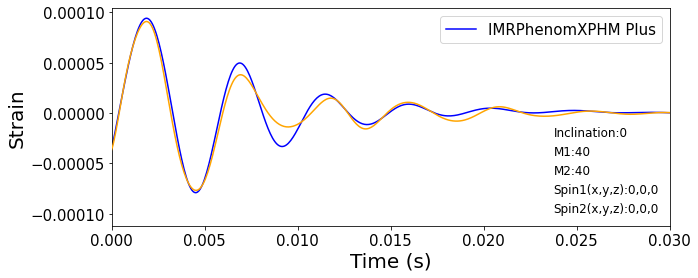

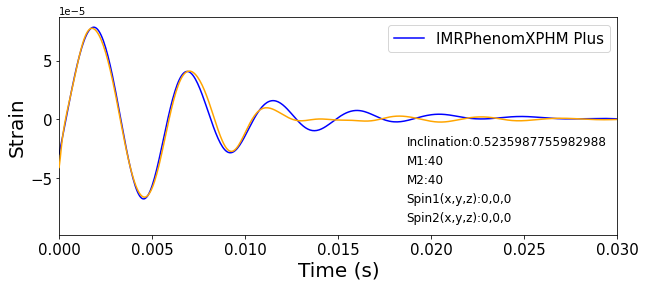

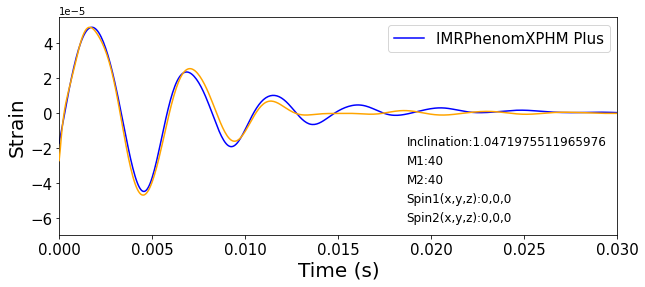

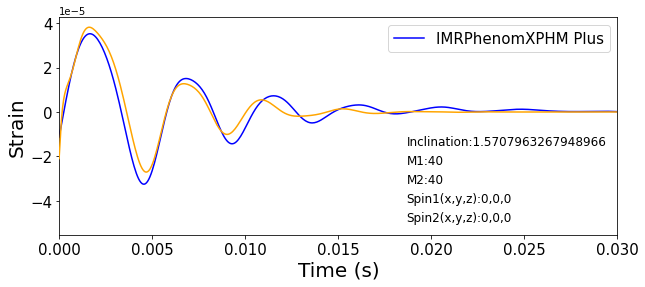

In [75]:
XPHMringdown_plots(40,40,0,0,0,0,0,0,test,con,bounds)
plt.savefig('4040_000')

(array([-1.25e-04, -1.00e-04, -7.50e-05, -5.00e-05, -2.50e-05,  0.00e+00,
         2.50e-05,  5.00e-05,  7.50e-05,  1.00e-04,  1.25e-04]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

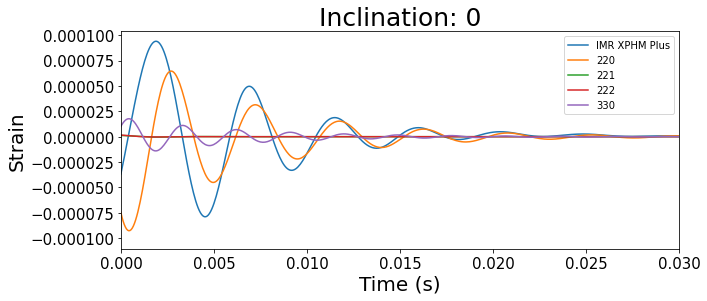

In [67]:
hp, hc = get_td_waveform(approximant="IMRPhenomXPHM",
                            mass1=40,
                            mass2=40,
                            delta_t=1.0/16384,
                            f_lower=30,
                            distance=1e-14,
                            inclination=0,
                            spin1x=0,
                            spin1y=0,
                            spin1z=0,
                            spin2x=0,
                            spin2y=0,
                            spin2z=0)

# sample times ---> timeseries
hp_smp_ts = TimeSeries(hp.sample_times, delta_t=1/16384, epoch=0)
cond = hp_smp_ts.crop(0.645,0)                                      

# h+/hx data ---> timeseries
hp_data = TimeSeries(hp, delta_t=1/16384, epoch=0)  
cond_hp = hp_data.crop(0.645,0)
hp_signal = cond_hp.numpy()                  

# repeat
hc_data = TimeSeries(hc, delta_t=1/16384, epoch=0)              
cond_hc = hc_data.crop(0.645,0)
hc_signal = cond_hc.numpy()                                         

# use for hp+hc ringdown analysis
time = cond.numpy()             
    
x = two_two_zero(time,91,.85,1e-4,2.43)
y = two_two_one(time,91,.85,1.2e-6,6.3)
z = two_two_two(time,91,.85,1.6e-6,6.3)
a = three_three_zero(time,91,.85,1.9e-5,5.3)
    
plt.figure(figsize=(10,4))
plt.plot(cond, cond_hp, label='IMR XPHM Plus')
plt.plot(x,label='220')
plt.plot(y,label='221')
plt.plot(z,label='222')
plt.plot(a,label='330')
plt.xlim(0, 0.03)
plt.legend()
plt.title(f'Inclination: {i}',fontsize=25)
plt.xlabel('Time (s)',fontsize=20)
plt.ylabel('Strain',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

66.96368863782986 0.3478932555941918 0.0001278631722423488 4.163729097167741 2.914815624344133e-05 2.4853456045399587 0.00031589223715318757 0.19806272776717765 2.8190777169478657e-05 0.8445841515313706 0.00038367307587999707 2.318931604571199 1.6376737046259492e-06 1.0444038747260114 3.477467350838375e-05 5.540966150985043 3.68174878097867e-05 5.680804814124741 5.289155778331162e-06 1.4690115873446037 4.056001465506913e-06 2.7814162870369112 4.3970003629305604e-05 4.986740676742585 6.356592341408209e-05 1.7633648832898359 1.1795581059841484e-06 2.1013225381545553 1.9891221963431667e-05 4.380145431779946 7.920831021795853e-05 3.9271260542353077
66.96368863782986 0.3478932555941918 2.8190777169478657e-05 0.8445841515313706 0.00038367307587999707 2.318931604571199 1.6376737046259492e-06 1.0444038747260114 4.056001465506913e-06 2.7814162870369112
66.34864293705303 0.37377547388262833 0.00014062775375206987 4.13900121808347 0.00019276127950870712 3.0313431240246755 0.00029971531584558394 0

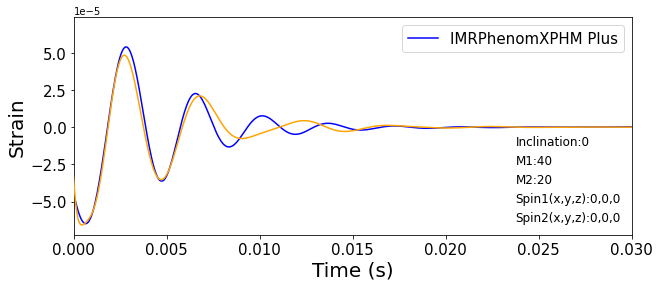

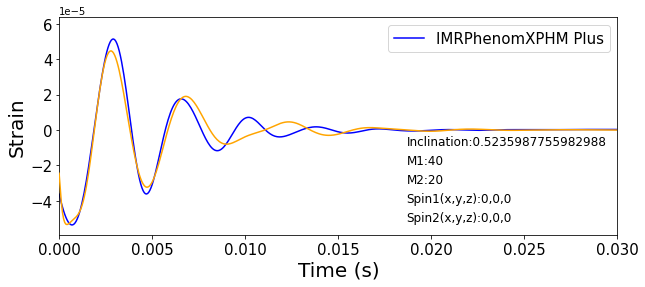

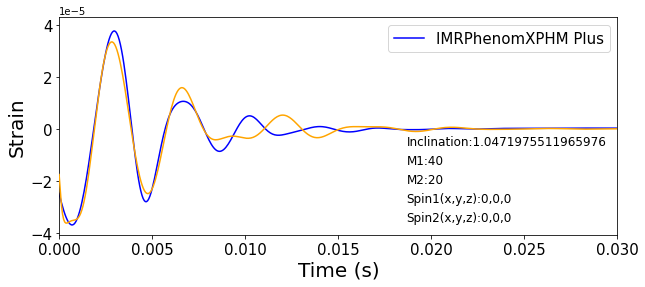

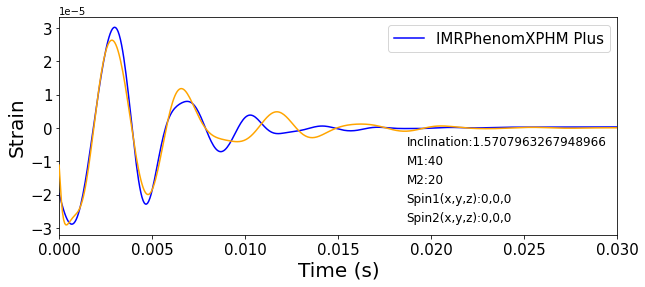

In [76]:
XPHMringdown_plots(40,20,0,0,0,0,0,0,test,con,bounds)
plt.savefig('4020_000')

In [113]:
def modes(l,m):    
    inclination = [0, np.pi/6, np.pi/3, np.pi/2]
    for i in inclination:        
        hp, hc = get_td_waveform(approximant="IMRPhenomXPHM",
                                    mass1=40,
                                    mass2=40,
                                    delta_t=1.0/16384,
                                    f_lower=30,
                                    distance=1e-14,
                                    inclination=i,
                                    spin1x=0,
                                    spin1y=0,
                                    spin1z=0,
                                    spin2x=0,
                                    spin2y=0,
                                    spin2z=0,
                                    mode_array=[[l,m]])

        # sample times ---> timeseries
        hp_smp_ts = TimeSeries(hp.sample_times, delta_t=1/16384, epoch=0)
        cond = hp_smp_ts.crop(0.645,0)                                      

        # h+/hx data ---> timeseries
        hp_data = TimeSeries(hp, delta_t=1/16384, epoch=0)  
        cond_hp = hp_data.crop(0.645,0)
        hp_signal = cond_hp.numpy()                  

        # repeat
        hc_data = TimeSeries(hc, delta_t=1/16384, epoch=0)              
        cond_hc = hc_data.crop(0.645,0)
        hc_signal = cond_hc.numpy()                                         

        # use for hp+hc ringdown analysis
        time = cond.numpy()             

        plt.figure(figsize=(10,4))
        plt.plot(cond, cond_hp, label='IMR XPHM Plus')
        plt.xlim(0, 0.03)
        plt.legend()
        plt.title(f'Inclination: {i}',fontsize=25)
        plt.xlabel('Time (s)',fontsize=20)
        plt.ylabel('Strain',fontsize=20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)

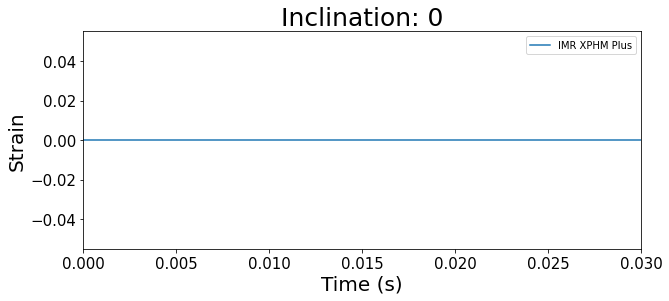

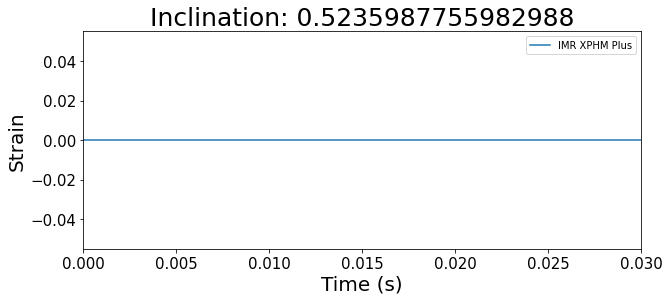

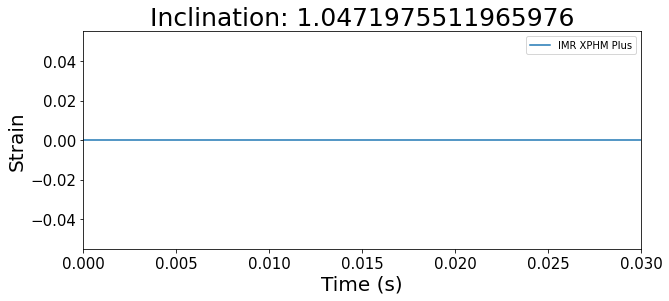

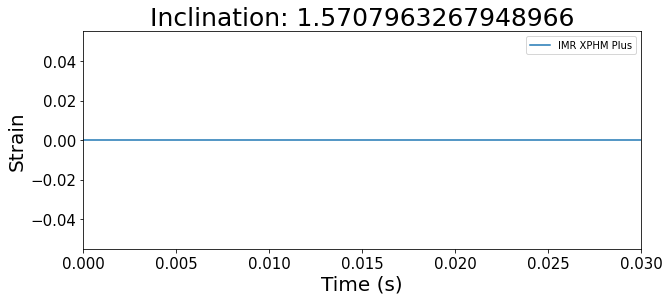

In [115]:
modes(2,1)

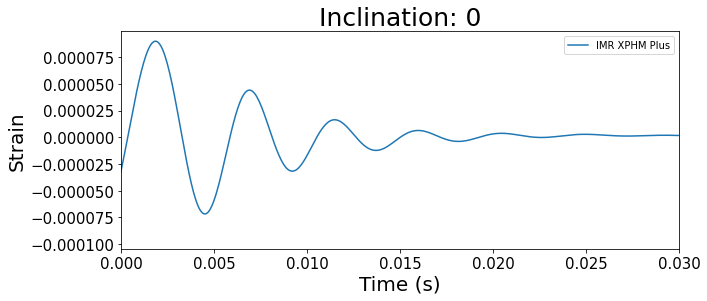

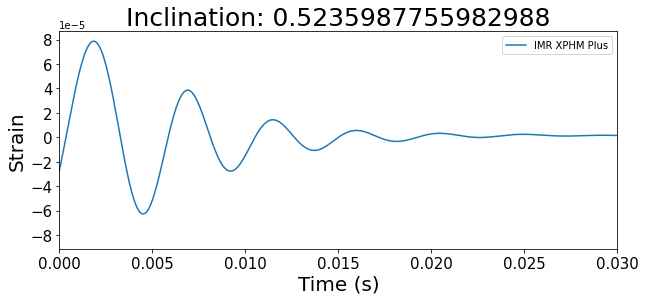

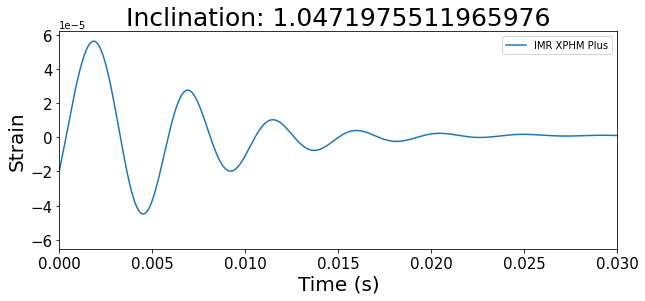

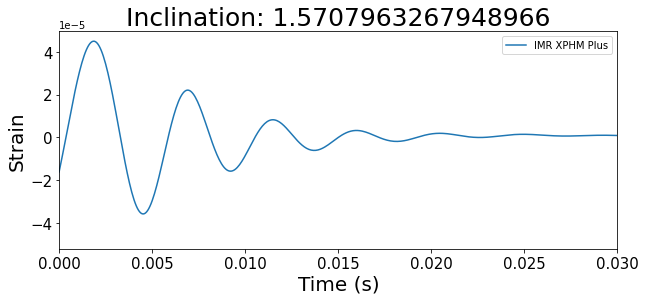

In [116]:
modes(2,2)

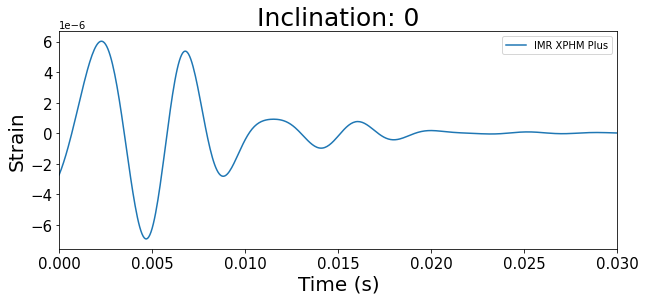

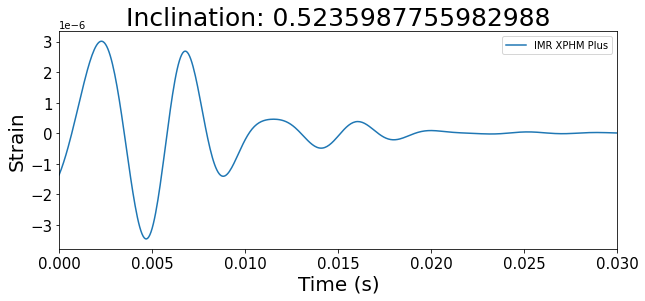

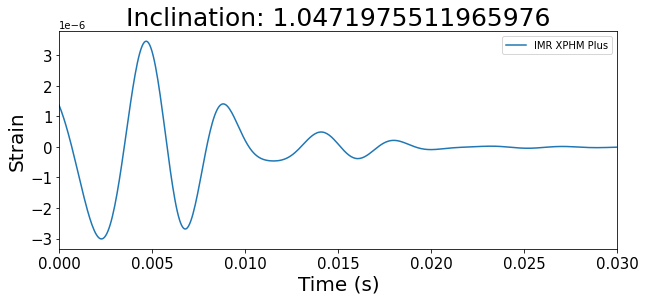

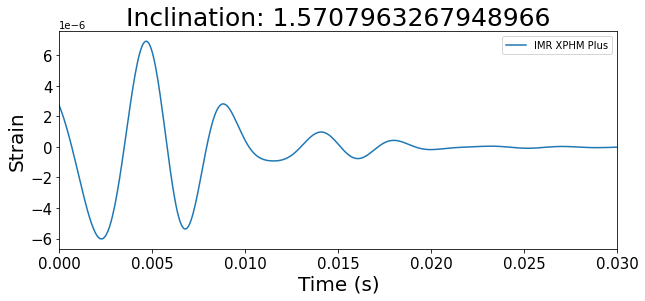

In [117]:
modes(3,2)

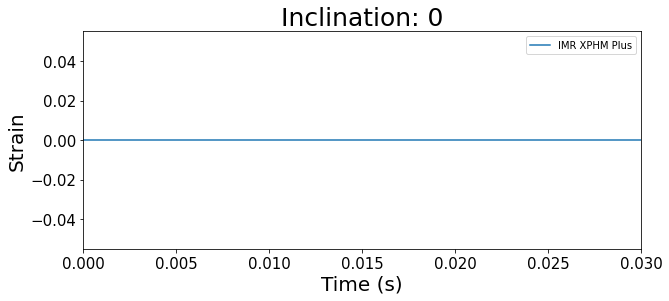

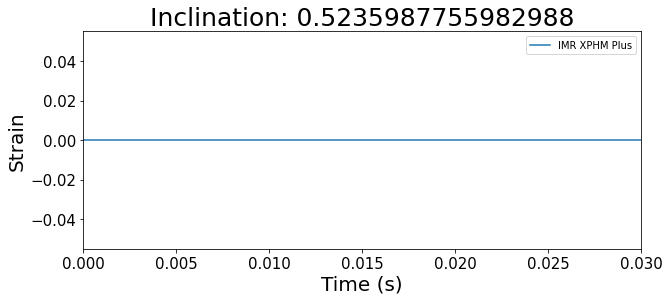

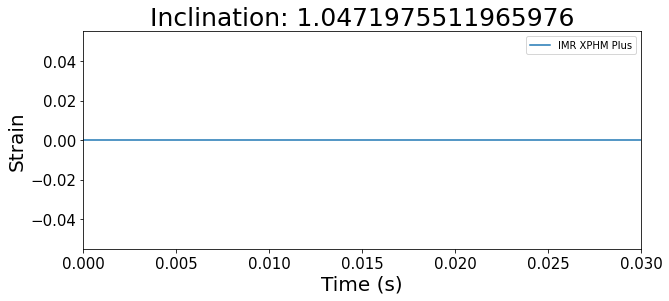

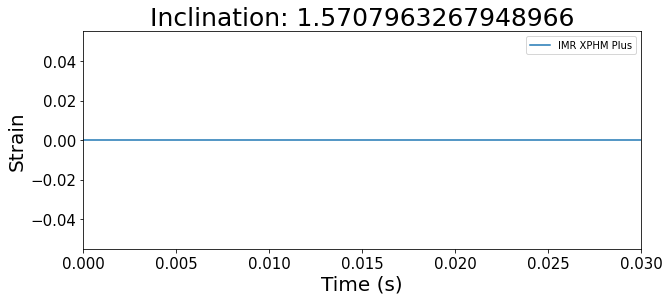

In [118]:
modes(3,3)

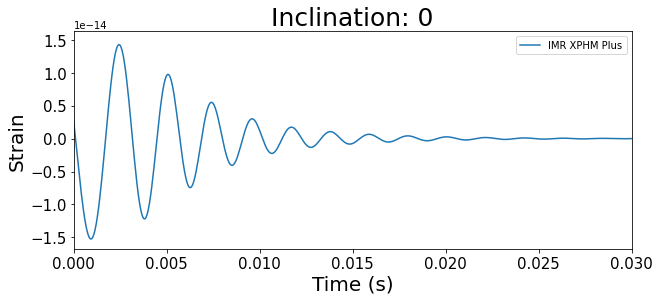

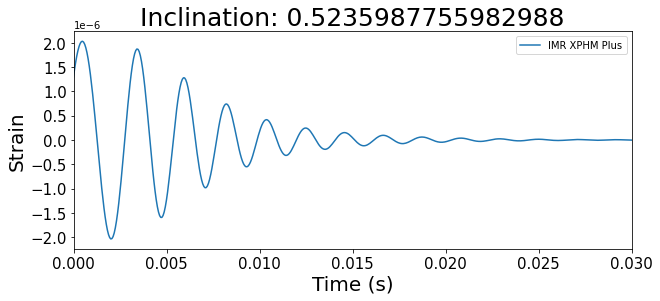

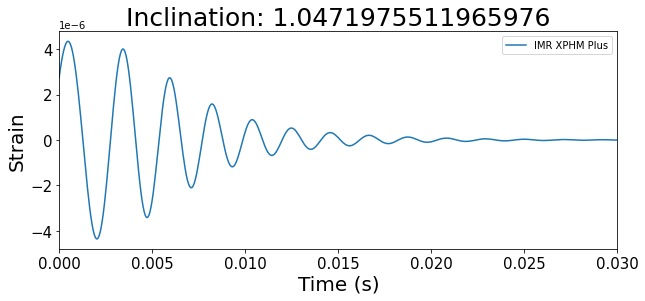

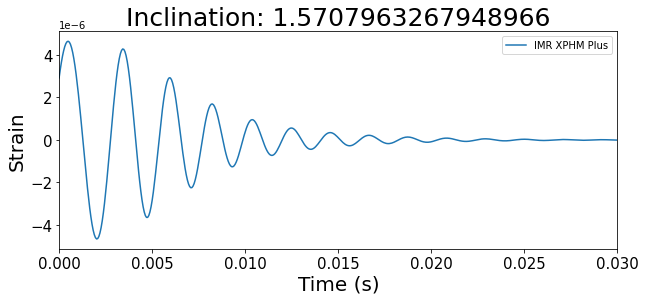

In [119]:
modes(4,4)